**Importing Modules**

In [77]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import nltk
import time

In [2]:
seed = 1306

np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

**Loading the Dataset**

In [3]:
ds = datasets.load_dataset('arbml/Arabic_Sentiment_Twitter_Corpus')

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 47000
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 11751
    })
})

In [5]:
train_val_test = ds['test'].train_test_split(test_size=0.5, seed=42)

ds = {
    "train": ds["train"],
    "validation": train_val_test["train"],
    "test": train_val_test["test"],
}

In [6]:
ds

{'train': Dataset({
     features: ['tweet', 'label'],
     num_rows: 47000
 }),
 'validation': Dataset({
     features: ['tweet', 'label'],
     num_rows: 5875
 }),
 'test': Dataset({
     features: ['tweet', 'label'],
     num_rows: 5876
 })}

In [7]:
ds['train'][0]

{'tweet': 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭',
 'label': 0}

In [8]:
ds['train'].features

{'tweet': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [9]:
from datasets import Features, Value, ClassLabel, Sequence

target_features = Features({
    "tweet": Value("string"),
    "label": ClassLabel(names=["neg", "pos"]),
    "tokens": Sequence(Value("string")),
    "length": Value("int32"),
})

**Tokenization**

In [10]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
text = 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭'
print(nltk.word_tokenize(text))

['اعترف', 'ان', 'بتس', 'كانو', 'شوي', 'شوي', 'يجيبو', 'راسي', 'لكن', 'اليوم', 'بالزايد', '😭']


In [12]:
def tokenize(example, tokenizer, max_length):
    tokens = tokenizer(example["tweet"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [13]:
max_length = 256

train_data = ds['train'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
valid_data = ds['validation'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)
test_data = ds['test'].map(
    tokenize, fn_kwargs={"tokenizer": nltk.word_tokenize, "max_length": max_length}, features=target_features
)

In [14]:
train_data[0]

{'tweet': 'اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭',
 'label': 0,
 'tokens': ['اعترف',
  'ان',
  'بتس',
  'كانو',
  'شوي',
  'شوي',
  'يجيبو',
  'راسي',
  'لكن',
  'اليوم',
  'بالزايد',
  '😭'],
 'length': 12}

In [15]:
train_data.features

{'tweet': Value('string'),
 'label': ClassLabel(names=['neg', 'pos']),
 'tokens': List(Value('string')),
 'length': Value('int32')}

In [16]:
len(train_data), len(valid_data), len(test_data)

(47000, 5875, 5876)

**Creating a Vocabulary**

In [17]:
from collections import Counter

counter = Counter(token for tokens in train_data["tokens"] for token in tokens)
special_tokens = ["<unk>", "<pad>"]
stoi = {tok: i for i, tok in enumerate(special_tokens + [t for t, c in counter.items() if c >= 5])}
itos = {i: tok for tok, i in stoi.items()}

In [18]:
len(stoi)

14926

In [19]:
unk_index = stoi["<unk>"]
pad_index = stoi["<pad>"]

In [20]:
# For the tokens that doesn't exist in stoi we should return unk_index
from collections import defaultdict
stoi = defaultdict(lambda: unk_index, stoi)

In [21]:
def lookup_indices(tokens):
    return [stoi[token] for token in tokens]

In [22]:
def lookup_tokens(ids):
    return [itos[Id] for Id in ids]

In [23]:
lookup_indices(['رغبتك', 'تنزل', 'ع', 'سمعي', 'مطر', '💙'])

[0, 6185, 239, 0, 4612, 3551]

**Numericalizing Data**

In [24]:
def numericalize_example(example):
    ids = lookup_indices(example["tokens"])
    return {"ids": ids}

In [25]:
train_data = train_data.map(numericalize_example)
valid_data = valid_data.map(numericalize_example)
test_data = test_data.map(numericalize_example)

Map:   0%|          | 0/5875 [00:00<?, ? examples/s]

Map:   0%|          | 0/5876 [00:00<?, ? examples/s]

In [26]:
test_data[0]

{'tweet': '#الهلال ب مدافع و محاور سوال ل الكوتش #زوران الفريق اللي ناقص لاعب مين ؟؟ 🤔 #الاهلي_الهلال',
 'label': 0,
 'tokens': ['#',
  'الهلال',
  'ب',
  'مدافع',
  'و',
  'محاور',
  'سوال',
  'ل',
  'الكوتش',
  '#',
  'زوران',
  'الفريق',
  'اللي',
  'ناقص',
  'لاعب',
  'مين',
  '؟؟',
  '🤔',
  '#',
  'الاهلي_الهلال'],
 'length': 20,
 'ids': [22,
  28,
  407,
  0,
  53,
  9026,
  0,
  380,
  0,
  22,
  2015,
  5001,
  890,
  2296,
  1669,
  374,
  982,
  101,
  22,
  23]}

In [27]:
train_data[10]['tweet']

'لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله أبقى أفر بيها لما ترجع بشر ماعرفه! وأنهي العلاقة من العرق.. قبل الدمع…'

In [28]:
train_data[10]["tokens"][:30]

['لو',
 'بيدي',
 'أرجع',
 'ساعتي',
 'وين',
 'أرجع؟',
 'إليا',
 'صدفه؟',
 'والله',
 'أبقى',
 'أفر',
 'بيها',
 'لما',
 'ترجع',
 'بشر',
 'ماعرفه',
 '!',
 'وأنهي',
 'العلاقة',
 'من',
 'العرق',
 '..',
 'قبل',
 'الدمع…']

In [29]:
lookup_indices(train_data[10]["tokens"][:30])

[106,
 107,
 108,
 0,
 109,
 0,
 0,
 0,
 110,
 111,
 0,
 112,
 113,
 114,
 115,
 0,
 116,
 0,
 117,
 68,
 0,
 81,
 118,
 0]

In [30]:
lookup_tokens(train_data[10]["ids"][:30])

['لو',
 'بيدي',
 'أرجع',
 '<unk>',
 'وين',
 '<unk>',
 '<unk>',
 '<unk>',
 'والله',
 'أبقى',
 '<unk>',
 'بيها',
 'لما',
 'ترجع',
 'بشر',
 '<unk>',
 '!',
 '<unk>',
 'العلاقة',
 'من',
 '<unk>',
 '..',
 'قبل',
 '<unk>']

In [31]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [32]:
train_data[10]

{'label': tensor(0),
 'length': tensor(24),
 'ids': tensor([106, 107, 108,   0, 109,   0,   0,   0, 110, 111,   0, 112, 113, 114,
         115,   0, 116,   0, 117,  68,   0,  81, 118,   0])}

**Creating Data Loaders**

In [33]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [34]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [35]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [36]:
next(iter(train_data_loader))

{'ids': tensor([[ 8063,   292,  3691,  ...,     1,     1,     1],
         [ 1293,  8800,    44,  ...,     1,     1,     1],
         [ 2388,   135,   449,  ...,     1,     1,     1],
         ...,
         [  185,     0,  4403,  ...,     1,     1,     1],
         [   99,  9347, 12725,  ...,     1,     1,     1],
         [    0,  3677, 11526,  ...,     1,     1,     1]]),
 'length': tensor([ 5,  8, 24,  7, 20, 19, 11, 15, 23,  5, 17,  4, 15,  3, 21, 19,  3,  5,
         24, 19, 19,  5,  3, 12, 23, 19, 11, 14,  7, 15, 19, 16, 13, 12,  4, 16,
          6,  9,  8, 21,  5,  7, 12, 16,  9,  7,  9,  4,  6, 22, 15, 23,  6,  5,
         24,  6, 30,  9,  7, 23, 28, 11, 19, 13,  9, 20, 12, 18,  3, 26,  6, 20,
          6, 14,  5, 13, 19,  8, 13,  8,  4,  3,  9, 23, 12,  8,  9, 27, 17,  5,
          5,  9,  3, 29,  5,  5,  9, 12, 14,  9,  9, 24, 20, 20, 15, 24,  5, 18,
         19, 14,  8, 13, 11, 24, 14, 22, 18,  4, 14, 16,  4,  7, 24, 20, 19,  5,
         12,  3,  6, 26,  3, 22,  3, 15, 24,  

**Building the Model**

**LSTM**

In [63]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        hidden = self.dropout(hidden[-1])
        # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [38]:
vocab_size = len(stoi)
embedding_dim = 128
hidden_dim = 256
output_dim = len(train_data.unique("label"))
n_layers = 2
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    dropout_rate,
    pad_index,
)

In [39]:
model

LSTM(
  (embedding): Embedding(37508, 128, padding_idx=1)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 5,723,138 trainable parameters


In [41]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [42]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(37508, 128, padding_idx=1)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [43]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"]
        length = batch["length"]
        label = batch["label"]
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [49]:
def evaluate(dataloader, model, criterion):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"]
            length = batch["length"]
            label = batch["label"]
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [47]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [50]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.01it/s]


epoch: 0
train_loss: 0.357, train_acc: 0.835
valid_loss: 0.259, valid_acc: 0.894


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.05it/s]


epoch: 1
train_loss: 0.287, train_acc: 0.876
valid_loss: 0.219, valid_acc: 0.909


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.99it/s]


epoch: 2
train_loss: 0.251, train_acc: 0.893
valid_loss: 0.200, valid_acc: 0.918


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.95it/s]


epoch: 3
train_loss: 0.230, train_acc: 0.903
valid_loss: 0.187, valid_acc: 0.924


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.04it/s]


epoch: 4
train_loss: 0.215, train_acc: 0.911
valid_loss: 0.179, valid_acc: 0.926


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.97it/s]


epoch: 5
train_loss: 0.202, train_acc: 0.918
valid_loss: 0.181, valid_acc: 0.923


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.98it/s]


epoch: 6
train_loss: 0.192, train_acc: 0.922
valid_loss: 0.169, valid_acc: 0.932


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.93it/s]


epoch: 7
train_loss: 0.183, train_acc: 0.925
valid_loss: 0.166, valid_acc: 0.932


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.05it/s]


epoch: 8
train_loss: 0.175, train_acc: 0.928
valid_loss: 0.160, valid_acc: 0.935


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.85it/s]

epoch: 9
train_loss: 0.172, train_acc: 0.929
valid_loss: 0.160, valid_acc: 0.936


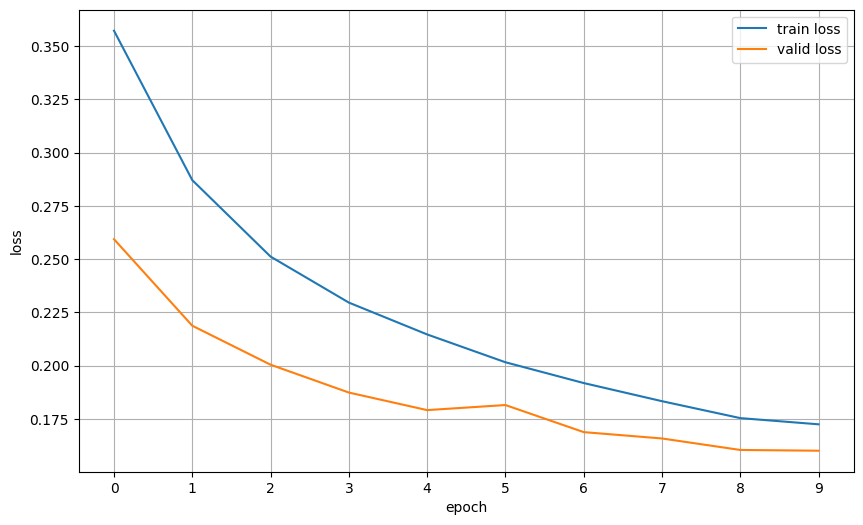

In [51]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

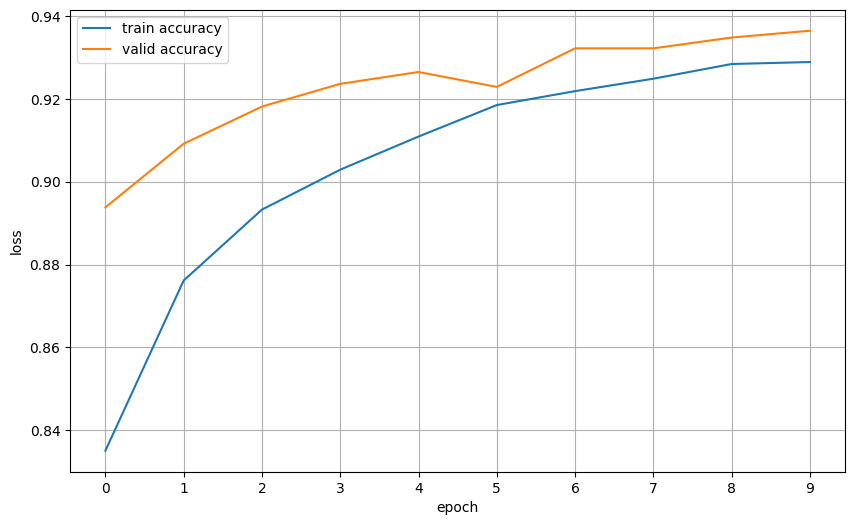

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [53]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.32it/s]


In [54]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.154, test_acc: 0.945


**GRU**

In [64]:
class GRU(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, hidden = self.gru(packed_embedded)
        # hidden = [n layers, batch size, hidden dim]
        hidden = self.dropout(hidden[-1])
        # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [56]:
model = GRU(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    dropout_rate,
    pad_index,
)

In [57]:
model

GRU(
  (embedding): Embedding(37508, 128, padding_idx=1)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 5,492,738 trainable parameters


In [59]:
model.apply(initialize_weights)

GRU(
  (embedding): Embedding(37508, 128, padding_idx=1)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [60]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [61]:
criterion = nn.CrossEntropyLoss()

In [62]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "gru.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.69it/s]


epoch: 0
train_loss: 0.547, train_acc: 0.706
valid_loss: 0.377, valid_acc: 0.828


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]


epoch: 1
train_loss: 0.413, train_acc: 0.803
valid_loss: 0.282, valid_acc: 0.877


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.67it/s]


epoch: 2
train_loss: 0.337, train_acc: 0.851
valid_loss: 0.236, valid_acc: 0.905


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.72it/s]


epoch: 3
train_loss: 0.295, train_acc: 0.871
valid_loss: 0.213, valid_acc: 0.917


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.67it/s]


epoch: 4
train_loss: 0.265, train_acc: 0.887
valid_loss: 0.198, valid_acc: 0.924


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.41it/s]


epoch: 5
train_loss: 0.243, train_acc: 0.898
valid_loss: 0.184, valid_acc: 0.928


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.15it/s]


epoch: 6
train_loss: 0.228, train_acc: 0.905
valid_loss: 0.184, valid_acc: 0.927


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.78it/s]


epoch: 7
train_loss: 0.216, train_acc: 0.909
valid_loss: 0.181, valid_acc: 0.930


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.97it/s]


epoch: 8
train_loss: 0.203, train_acc: 0.915
valid_loss: 0.176, valid_acc: 0.932


evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.93it/s]

epoch: 9
train_loss: 0.195, train_acc: 0.919
valid_loss: 0.177, valid_acc: 0.931


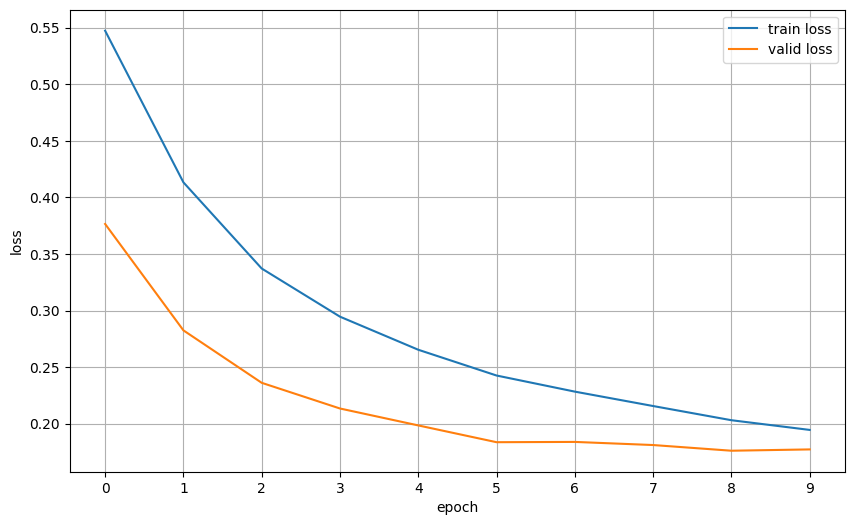

In [65]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

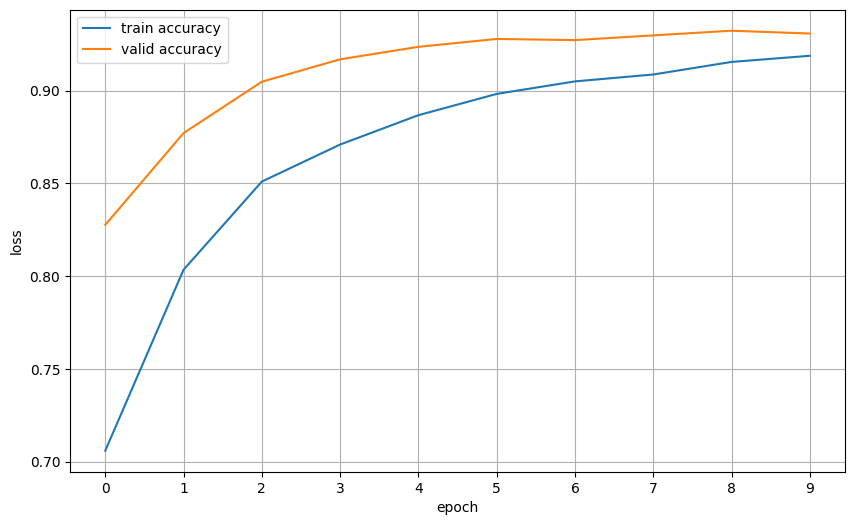

In [66]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [67]:
model.load_state_dict(torch.load("gru.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.77it/s]


In [68]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.166, test_acc: 0.938


In [71]:
def build_gru():
    return GRU(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate, pad_index)

def build_lstm():
    return LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_rate, pad_index)

In [69]:
def eval_model(ckpt_path, model_fn):
    model = model_fn()
    model.load_state_dict(torch.load(ckpt_path))
    t0 = time.time()
    loss, acc = evaluate(test_data_loader, model, criterion)
    dt = time.time() - t0
    return loss, acc, dt

In [74]:
loss_lstm, acc_lstm, t_lstm = eval_model("lstm.pt", build_lstm)
loss_gru,  acc_gru,  t_gru  = eval_model("gru.pt",  build_gru)

evaluating...: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.67it/s]


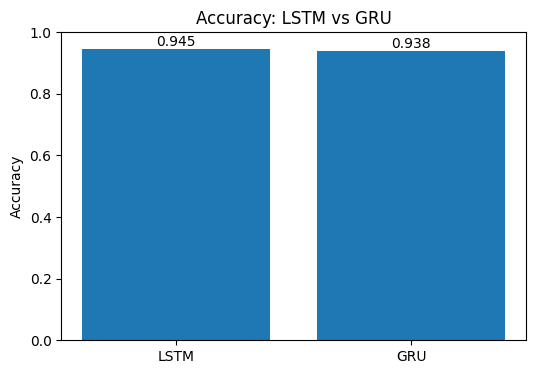

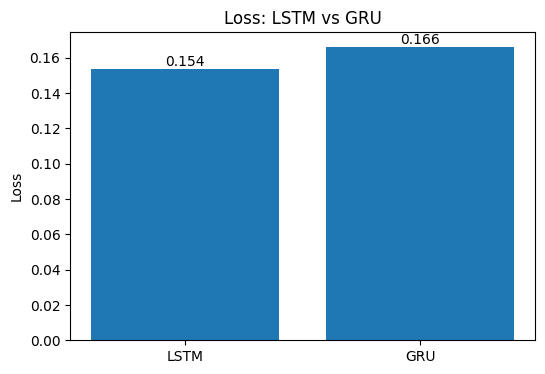

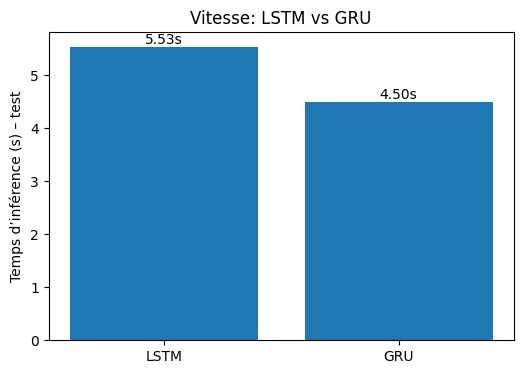

In [75]:
labels = ["LSTM", "GRU"]
accs   = [acc_lstm, acc_gru]
losses = [loss_lstm, loss_gru]
times  = [t_lstm, t_gru]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, accs)
plt.ylabel("Accuracy")
plt.title("Accuracy: LSTM vs GRU")
plt.ylim(0, 1)
for b, v in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom")
plt.show()

plt.figure(figsize=(6,4))
bars = plt.bar(labels, losses)
plt.ylabel("Loss")
plt.title("Loss: LSTM vs GRU")
for b, v in zip(bars, losses):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom")
plt.show()

plt.figure(figsize=(6,4))
bars = plt.bar(labels, times)
plt.ylabel("Temps d’inférence (s) – test")
plt.title("Vitesse: LSTM vs GRU")
for b, v in zip(bars, times):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.2f}s", ha="center", va="bottom")
plt.show()